In [2]:
import datajoint as dj
from aeon.dj_pipeline.report import *

[2022-06-30 15:38:17,222][INFO]: Connecting jaeronga@aeon-db2:3306
[2022-06-30 15:38:17,288][INFO]: Connected jaeronga@aeon-db2:3306


In [11]:
key_id = 10
key = (analysis.InArena * analysis.InArenaEnd).fetch('KEY')[key_id]
in_arena_start, in_arena_end = (
    analysis.InArena * analysis.InArenaEnd & key
).fetch1("in_arena_start", "in_arena_end")

print(key)
print(in_arena_start)
print(in_arena_end)

# subject's position data in the time_slices
position = analysis.InArenaSubjectPosition.get_position(key)
position.rename(columns={"position_x": "x", "position_y": "y"}, inplace=True)
position_minutes_elapsed = (
    position.index - in_arena_start
).total_seconds() / 60

{'experiment_name': 'exp0.1-r0', 'subject': 'BAA-1099790', 'in_arena_start': datetime.datetime(2021, 6, 29, 13, 6, 34, 761660)}
2021-06-29 13:06:34.761660
2021-06-29 17:11:26.405819


/tmp/ipykernel_773206/3446466821.py:201: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


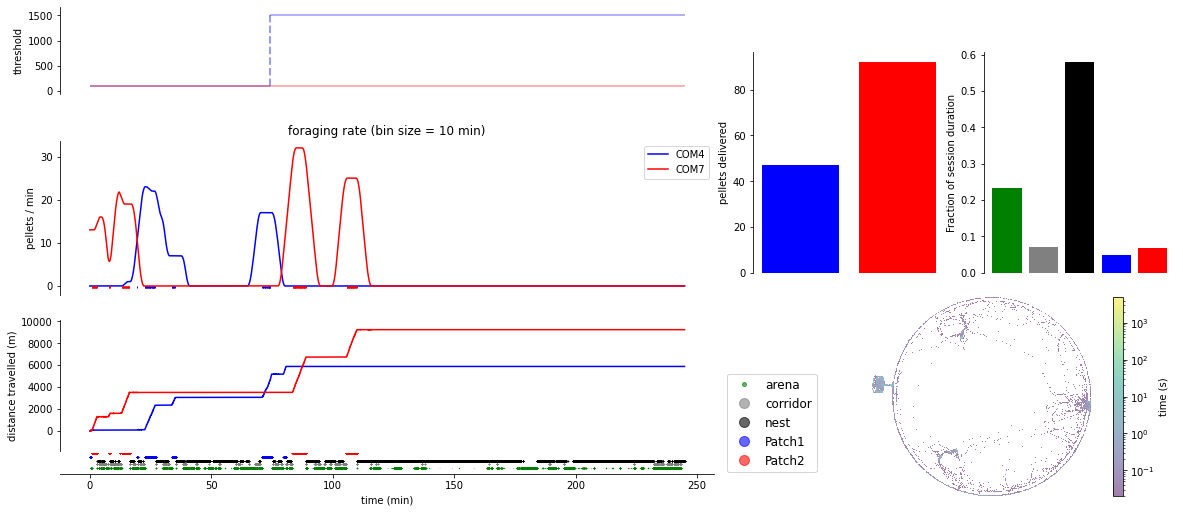

In [39]:
# figure
fig = plt.figure(figsize=(20, 9))
gs = fig.add_gridspec(22, 5)
threshold_ax = fig.add_subplot(gs[:4, :3])
rate_ax = fig.add_subplot(gs[6:13, :3])
distance_ax = fig.add_subplot(gs[14:20, :3])
ethogram_ax = fig.add_subplot(gs[20, :3])
position_ax = fig.add_subplot(gs[13:, 3:])
pellet_ax = fig.add_subplot(gs[2:12, 3])
time_dist_ax = fig.add_subplot(gs[2:12, 4:])

# position plot
non_nan = np.logical_and(~np.isnan(position.x), ~np.isnan(position.y))
analysis_plotting.heatmap(
    position[non_nan], 50, ax=position_ax, bins=500, alpha=0.5
)

# event rate plots
in_arena_food_patches = (
    analysis.InArena
    * acquisition.ExperimentFoodPatch.join(
        acquisition.ExperimentFoodPatch.RemovalTime, left=True
    )
    & key
    & "in_arena_start >= food_patch_install_time"
    & 'in_arena_start < IFNULL(food_patch_remove_time, "2200-01-01")'
).proj("food_patch_description")

for food_patch_key in in_arena_food_patches.fetch(as_dict=True):
    pellet_times_df = (
        (
            acquisition.FoodPatchEvent * acquisition.EventType
            & food_patch_key
            & 'event_type = "TriggerPellet"'
            & f'event_time BETWEEN "{in_arena_start}" AND "{in_arena_end}"'
        )
        .proj("event_time")
        .fetch(format="frame", order_by="event_time")
        .reset_index()
    )
    pellet_times_df.set_index("event_time", inplace=True)
    analysis_plotting.rateplot(
        pellet_times_df,
        window="600s",
        frequency=500,
        ax=rate_ax,
        smooth="120s",
        start=in_arena_start,
        end=in_arena_end,
        color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]],
        label=food_patch_key['food_patch_serial_number']
    )
    
    # wheel data
    wheel_data = acquisition.FoodPatchWheel.get_wheel_data(
        experiment_name=key["experiment_name"],
        start=pd.Timestamp(in_arena_start),
        end=pd.Timestamp(in_arena_end),
        patch_name=food_patch_key["food_patch_description"],
        using_aeon_io=True,
    )

    minutes_elapsed = (wheel_data.index - in_arena_start).total_seconds() / 60
    distance_ax.plot(
        minutes_elapsed,
        wheel_data.distance_travelled.values,
        color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]],
    )
    
    # plot wheel threshold
    wheel_time, wheel_threshold = (acquisition.WheelState.Time & 
            food_patch_key & 
            f'state_timestamp between "{in_arena_start}" and "{in_arena_end}"').fetch('state_timestamp', 'threshold')
    wheel_time -= in_arena_start 
    wheel_time /= datetime.timedelta(minutes=1)
    
    wheel_time = np.append(wheel_time, position_minutes_elapsed[-1])
    
    for i in range(0, len(wheel_time) - 1):
        threshold_ax.hlines(y=wheel_threshold[i], xmin=wheel_time[i], xmax=wheel_time[i + 1], linewidth=2, 
                            color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]],
                            alpha=0.3
                            )
    threshold_change_ind = np.where(wheel_threshold[:-1] != wheel_threshold[1:])[0]
    threshold_ax.vlines(wheel_time[threshold_change_ind], 
            ymin=wheel_threshold[threshold_change_ind], 
            ymax=wheel_threshold[threshold_change_ind+1], 
            linewidth=2, linestyle='--',
            color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]], alpha=0.4)
    
# ethogram
in_arena, in_corridor, arena_time, corridor_time = (
    analysis.InArenaTimeDistribution & key
).fetch1(
    "in_arena",
    "in_corridor",
    "time_fraction_in_arena",
    "time_fraction_in_corridor",
)
nest_keys, in_nests, nests_times = (
    analysis.InArenaTimeDistribution.Nest & key
).fetch("KEY", "in_nest", "time_fraction_in_nest")
patch_names, in_patches, patches_times = (
    analysis.InArenaTimeDistribution.FoodPatch * acquisition.ExperimentFoodPatch
    & key
).fetch("food_patch_description", "in_patch", "time_fraction_in_patch")

ethogram_ax.plot(
    position_minutes_elapsed[in_arena],
    np.full_like(position_minutes_elapsed[in_arena], 0),
    ".",
    color=InArenaSummaryPlot.color_code["arena"],
    markersize=0.2,
    alpha=0.6,
    label=f"arena",
)
ethogram_ax.plot(
    position_minutes_elapsed[in_corridor],
    np.full_like(position_minutes_elapsed[in_corridor], 1),
    ".",
    color=InArenaSummaryPlot.color_code["corridor"],
    markersize=0.5,
    alpha=0.6,
    label=f"corridor",
)
for in_nest in in_nests:
    ethogram_ax.plot(
        position_minutes_elapsed[in_nest],
        np.full_like(position_minutes_elapsed[in_nest], 2),
        ".",
        color=InArenaSummaryPlot.color_code["nest"],
        markersize=0.5,
        alpha=0.6,
        label=f"nest",
    )
for patch_idx, (patch_name, in_patch) in enumerate(
    zip(patch_names, in_patches)
):
    ethogram_ax.plot(
        position_minutes_elapsed[in_patch],
        np.full_like(position_minutes_elapsed[in_patch], (patch_idx + 3)),
        ".",
        color=InArenaSummaryPlot.color_code[patch_name],
        markersize=0.5,
        alpha=0.6,
        label=f"{patch_name}",
    )

# pellet
patch_names, patches_pellet = (
    analysis.InArenaSummary.FoodPatch * acquisition.ExperimentFoodPatch & key
).fetch("food_patch_description", "pellet_count")
pellet_ax.bar(
    range(len(patches_pellet)),
    patches_pellet,
    color=[InArenaSummaryPlot.color_code[n] for n in patch_names],
)

# time distribution
time_fractions = [arena_time, corridor_time]
colors = [InArenaSummaryPlot.color_code["arena"], InArenaSummaryPlot.color_code["corridor"]]
time_fractions.extend(nests_times)
colors.extend([InArenaSummaryPlot.color_code["nest"] for _ in nests_times])
time_fractions.extend(patches_times)
colors.extend([InArenaSummaryPlot.color_code[n] for n in patch_names])
time_dist_ax.bar(range(len(time_fractions)), time_fractions, color=colors)

# cosmetic
rate_ax.legend()
rate_ax.sharex(distance_ax)
fig.subplots_adjust(hspace=0.1)
rate_ax.set_ylabel("pellets / min")
rate_ax.set_title("foraging rate (bin size = 10 min)")
distance_ax.set_ylabel("distance travelled (m)")
threshold_ax.set_ylabel("threshold")
threshold_ax.set_ylim([threshold_ax.get_ylim()[0] - 100, threshold_ax.get_ylim()[1] + 100])
ethogram_ax.set_xlabel("time (min)")
analysis_plotting.set_ymargin(distance_ax, 0.2, 0.1)
for ax in (rate_ax, distance_ax, pellet_ax, time_dist_ax, threshold_ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)

ethogram_ax.legend(loc='center left', 
                   bbox_to_anchor=(1.01, 2.5), prop={'size': 12},
                   markerscale=40,
                   ) 
ethogram_ax.spines["top"].set_visible(False)
ethogram_ax.spines["right"].set_visible(False)
ethogram_ax.spines["left"].set_visible(False)
ethogram_ax.tick_params(left=False, labelleft=False)
analysis_plotting.set_ymargin(ethogram_ax, 0.4, 0)

position_ax.set_aspect("equal")
position_ax.set_axis_off()

pellet_ax.set_ylabel("pellets delivered")
time_dist_ax.set_ylabel("Fraction of session duration")

plt.tight_layout()
fig.show()

In [16]:
wheel_threshold

array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100., 1500.])

In [23]:
wheel_time

array([0.00013865, 19.434972333333334, 22.726538666666666,
       22.879405316666666, 23.034872, 23.205572333333333, 23.435872,
       23.668839, 23.887172333333332, 24.064272, 24.253272,
       24.443238983333334, 24.64470565, 24.80090565, 24.973972316666668,
       25.304138666666667, 25.47613865, 25.649271983333332,
       25.830705666666667, 26.017639, 26.193671983333335,
       26.40470566666667, 26.57310565, 26.738172333333335,
       33.79057233333333, 33.994005316666666, 34.197705666666664,
       34.44197233333333, 34.61690566666667, 34.858305666666666,
       35.056372333333336, 71.05550566666666, 71.19780533333333,
       71.50957231666666, 71.66637231666667, 71.94233866666667, 72.103839,
       72.29610565, 72.51560531666667, 72.81097233333334, 73.114272,
       73.28393865, 73.46630565, 73.62647198333333, 73.77723898333333,
       73.94443898333333, 74.12590565, 74.27870566666667,
       244.86060060000003], dtype=object)

array([], dtype=float64)

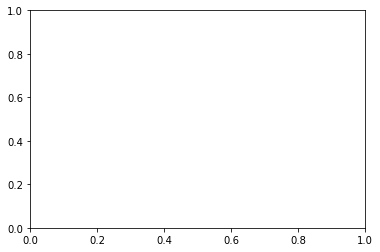

In [42]:
threshold_change_ind = np.where(wheel_threshold[:-1] != wheel_threshold[1:])[0]
plt.vlines(wheel_time[threshold_change_ind], 
        ymin=wheel_threshold[threshold_change_ind], 
        ymax=wheel_threshold[threshold_change_ind+1], 
        linewidth=2, linestyle='--',
        color=InArenaSummaryPlot.color_code[food_patch_key["food_patch_description"]], alpha=0.4)
plt.show()

In [36]:

wheel_threshold[threshold_change_ind-1]

array([100.])